how to use openVINO.  

https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/002-openvino-api/002-openvino-api.ipynb
https://github.com/openvinotoolkit/openvino_notebooks/blob/e2ec5ab418103de836d4a0f5b6f90ccfb25ea65c/notebooks/003-hello-segmentation/003-hello-segmentation.ipynb



In [ ]:
%pip install openvino 


Initialize OpenVINO runtime and list up all the available devices

In [1]:
import openvino as ov

core = ov.Core()

devices = core.available_devices
print(devices)

for device in devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device_name}")



['CPU', 'GPU', 'NPU']
Genuine Intel(R) 0000
Intel(R) Graphics (iGPU)
Intel(R) NPU


list up SUPPORTED_PROPERTIES for GPU device

In [2]:
device ="GPU"

print(f"{device} SUPPORTED_PROPERTIES:\n")
supported_properties = core.get_property(device, "SUPPORTED_PROPERTIES")
indent = len(max(supported_properties, key=len))

for property_key in supported_properties:
    if property_key not in ('SUPPORTED_METRICS', 'SUPPORTED_CONFIG_KEYS', 'SUPPORTED_PROPERTIES'):
        try:
            property_val = core.get_property(device, property_key)
        except TypeError:
            property_val = 'UNSUPPORTED TYPE'
        print(f"{property_key:<{indent}}: {property_val}")

GPU SUPPORTED_PROPERTIES:

AVAILABLE_DEVICES               : ['0']
RANGE_FOR_ASYNC_INFER_REQUESTS  : (1, 2, 1)
RANGE_FOR_STREAMS               : (1, 2)
OPTIMAL_BATCH_SIZE              : 1
MAX_BATCH_SIZE                  : 1
DEVICE_ARCHITECTURE             : GPU: vendor=0x8086 arch=v785.128.0
FULL_DEVICE_NAME                : Intel(R) Graphics (iGPU)
DEVICE_UUID                     : 8680607d000000000002000000000000
DEVICE_LUID                     : 6e12010000000000
DEVICE_TYPE                     : Type.INTEGRATED
DEVICE_GOPS                     : {<Type: 'float16'>: 3276.800048828125, <Type: 'float32'>: 1638.4000244140625, <Type: 'int8_t'>: 6553.60009765625, <Type: 'uint8_t'>: 6553.60009765625}
OPTIMIZATION_CAPABILITIES       : ['FP32', 'BIN', 'FP16', 'INT8', 'EXPORT_IMPORT']
GPU_DEVICE_TOTAL_MEM_SIZE       : 13610409984
GPU_UARCH_VERSION               : 785.128.0
GPU_EXECUTION_UNITS_COUNT       : 64
GPU_MEMORY_STATISTICS           : {}
PERF_COUNT                      : False
MODEL_PR

import openvino notebook util

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file

a pre-trained road-segmentation-adas-0001 model from the Open Model Zoo is used. ADAS stands for Advanced Driver Assistance Services. 
The model recognizes four classes: background, road, curb and mark

In [4]:
from pathlib import Path

base_model_dir = Path("./model").expanduser()

model_name = "road-segmentation-adas-0001"
model_xml_name = f'{model_name}.xml'
model_bin_name = f'{model_name}.bin'

model_xml_path = base_model_dir / model_xml_name

if not model_xml_path.exists():
    model_xml_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"
    model_bin_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f'{model_name} already downloaded to {base_model_dir}')

road-segmentation-adas-0001 already downloaded to model


select inference device.

In [5]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

read  model and creates a compiled model.

In [6]:
core = ov.Core()

model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

load image file

'data\empty_road_mapillary.jpg' already exists.


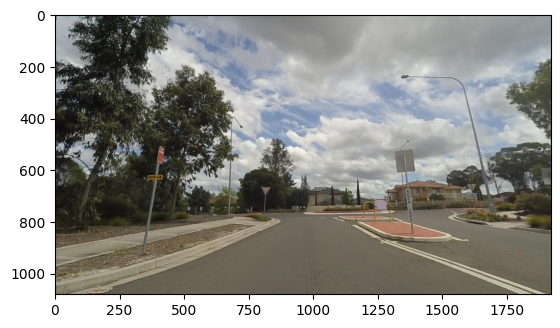

In [7]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg",
    directory="data"
)

# The segmentation network expects images in BGR format.
image = cv2.imread(str(image_filename))

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image)

run inference. 

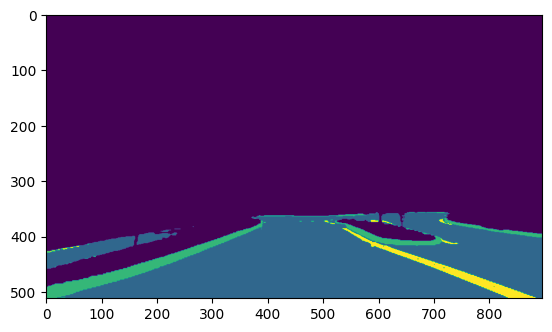

In [8]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))